In [18]:
import os, random
import numpy as np
import multiprocessing as mp
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt


In [19]:
#we need faster code for the next part, lets use swap pop and multicore processing

try:
    mp.set_start_method("fork", force=True)
except RuntimeError:
    pass

def hat_fast(n, rng):
    nums = list(range(1, n + 1))
    while len(nums) > 1:
        # remove a
        i = rng.randrange(len(nums))
        a = nums[i]
        nums[i] = nums[-1]; nums.pop()

        # remove b (from remaining)
        j = rng.randrange(len(nums))
        b = nums[j]
        nums[j] = nums[-1]; nums.pop()

        nums.append(a - b if a >= b else b - a)
    return nums[0]


def _worker(n, trials, seed):
    rng = random.Random(seed)
    counts = np.zeros(n + 1, dtype=np.int64)
    for _ in range(trials):
        counts[hat_fast(n, rng)] += 1
    return counts


def multicore_hat(n, trials, workers=None, seed=0):
    workers = workers or (os.cpu_count() or 4)

    base, extra = divmod(trials, workers)
    jobs = [(n, base + (i < extra), seed + 1000003 * i) for i in range(workers)]

    with mp.Pool(processes=workers) as pool:
        parts = pool.starmap(_worker, jobs)

    return np.sum(parts, axis=0)

In [21]:
n = 2026
trials = 1000000
seed = 1
random.seed(seed)

counts = multicore_hat(n, trials, workers=8, seed=1) 

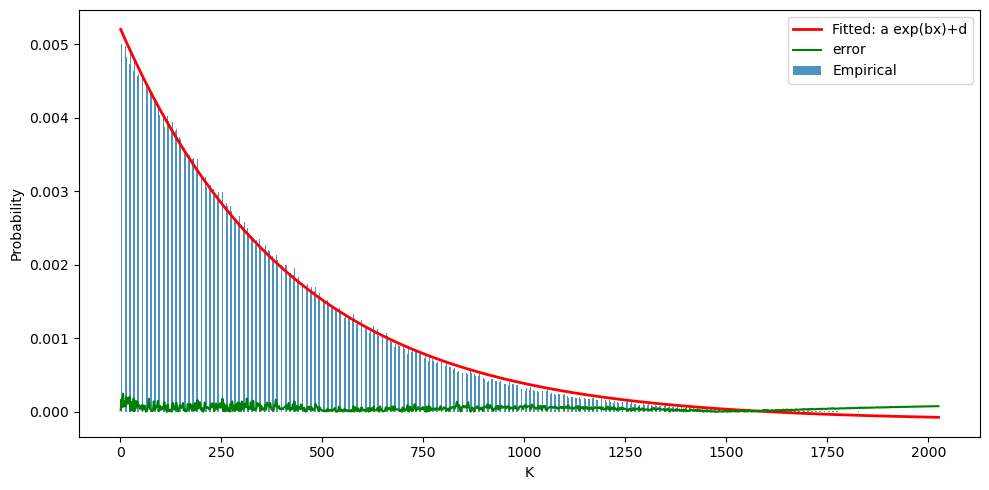

a=0.00533562, b=-0.00235644, d=-0.000121001


In [26]:
df = pd.DataFrame({
    "Final Number": np.arange(n + 1, dtype=int),
    "Frequency": counts.astype(int),
})

df["Probabilities"] = df["Frequency"] / df["Frequency"].sum()

parity = (n * (n + 1) // 2) % 2
mask = (df["Final Number"] > 0) & ((df["Final Number"] % 2) == parity)
x_data = df.loc[mask, "Final Number"].to_numpy(dtype=float)
y_data = df.loc[mask, "Probabilities"].to_numpy(dtype=float)

def exponential_func(x, a, b, d):
    return a * np.exp(b * x) + d

initial_guesses = [float(y_data[0]), -0.05, 0.0]

popt, pcov = curve_fit(exponential_func, x_data, y_data, p0=initial_guesses, maxfev=50_000)
a_opt, b_opt, d_opt = popt

y_fit = exponential_func(x_data, a_opt, b_opt, d_opt)
y_error = np.abs(y_fit - y_data)

fig = plt.figure(figsize=(10, 5))
plt.bar(df["Final Number"], df["Probabilities"], width=0.9, alpha=0.8, label="Empirical")
plt.plot(x_data, y_fit, "r-", linewidth=2, label="Fitted: a exp(bx)+d")
plt.plot(x_data, y_error, "g-", linewidth=1.5, label="error")
plt.xlabel("K")
plt.ylabel("Probability")
plt.legend()
plt.tight_layout()
plt.show()

fig.savefig(fname = 'approx.png', dpi=600, bbox_inches="tight", pad_inches=0)

print(f"a={a_opt:.6g}, b={b_opt:.6g}, d={d_opt:.6g}")